# OA3802: Computational Methods for Data Analytics <br>
<br>

## Geospacial Vegetation Analysis for Bushfire Prediction<br>

## Team Members:
Maj Jason Stisser <br>
LCDR Alex Bedley <br>
MAJ Conrad Urban <br>
CAPT Gary Tyler <br>

## OA3802 Tools Used: AWS, NPS HPC, SQLite, PowerBI, API, Geospacial Data.

## BLUF: 
This project aims to overcome the challenges of integrating large-scale satellite vegetation land cover data into bushfire prediction models for southeastern Australia by processing up to 300GB of complex geospatial data sourced from AWS S3 to inform better environmental and risk assessments.

During the preparation of data for a wider study on fire predictors in southeastern Australia, significant challenges were met when attempting to include vegetation land cover. These challenges stem from the geospatial nature of the data, its vast size, and difference in structure as compared to other data used. This project aims to address these challenges and will involve accessing and processing largescale satellite data of vegetation land cover in Australia, with the purpose of informing Bushfire predictions. The data is in the form of many TIFF files stored on a public AWS server (S3 bucket) within a complex file structure. Ultimately, this data will then be joined with a previously created bushfire prediction data frame. 

## Data Source & Description
* Source: AWS S3 bucket: dea-public-data <br>
  - Public Data Set from Digital Earth Australia <br>
  - Access via: https://knowledge.dea.ga.gov.au/data/product/dea-fractional-cover-percentiles-landsat/ <br>
* Content: The dataset includes aggregate satellite imagery data, specifically focused on land cover classification across Australia. <br>
* Size of the files: Up to 300 GB of data. This includes approximately 60,000 separate files in a folder structure based on time and location of the observations. The geographic and temporal range of these files was heavily truncated for analysis; the final size of the data is significantly less. <br>

* An example of the AWS Bucket structure is shown below:


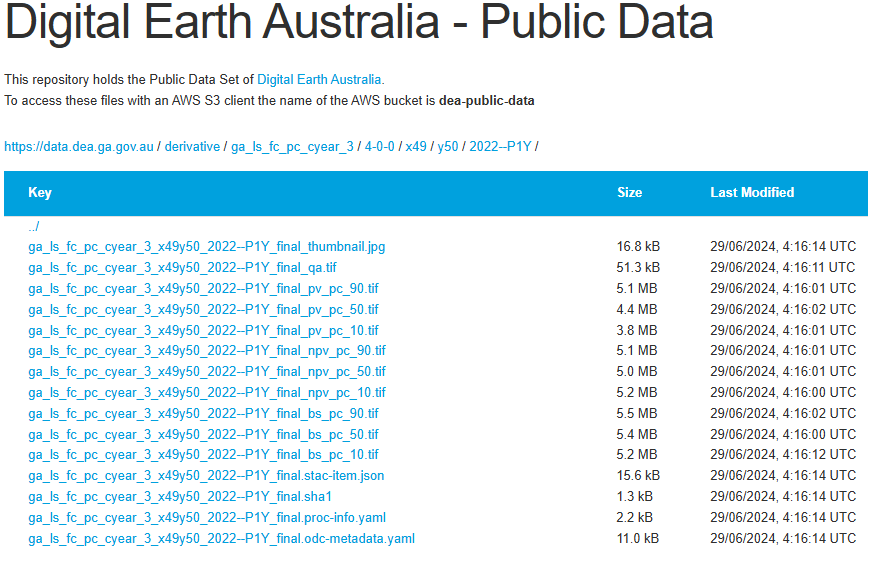

Key data of interest for this project included subsets of Fractional Cover, Percentil data. This data is aggregated over an annual timeframe and constitutes typical and extreme values for various classes of vegetation cover. The following are the naming conventions for the files of interest:

* `ga_ls_fc_pc` refers to all the files that contain the Fractional Cover Percentile data.
* `bs_pc` references the Bare Soil Percentile data.
* `pv_pc` references the Photosynthetic Vegetation Percentile data (i.e. Green Vegitation).
* `npv_pc` references the Non-Plant Vegetation Percentile data (i.e. Brown/Dry Vegitation). 
* files ending in `pc_10`, `pc_50` and `pc_90` refer to the 10th, 50th, and 90th percentile data respectively.


An example of a typical unprocessed file is shown below:

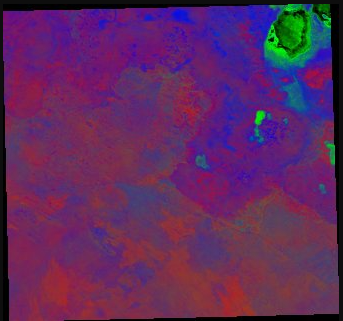

This is an aggregate image accross PV,NPV and BS images with colours and saturation representing different percentiles.

This project aggregated the data into a previously developed grid for analysis. The following is an example of the base data structure for the grid (work in progress from an ongoing Thesis):

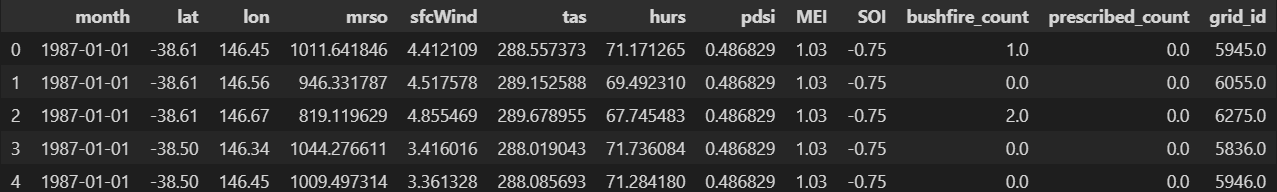

Note that each row represents a specific grid square for a specific month from 1987 through to 2018.

Other variables shown above are from sources outside the scope of this project. In short, they constitute a range of other features relevent to bushfire prediction.

## Data and Database

Initially, the group looked at pulling data for all of South Eastern Australia, however, the API calls to gather all of the data would takea minimum of 30 days to run. In order to verify that the code functions correctly, the specific region shown by blue boxes in the photos below were pulled for analysis by the team; this region is prone to a significant amount of bushfires.

Location selected for truncated data pull:

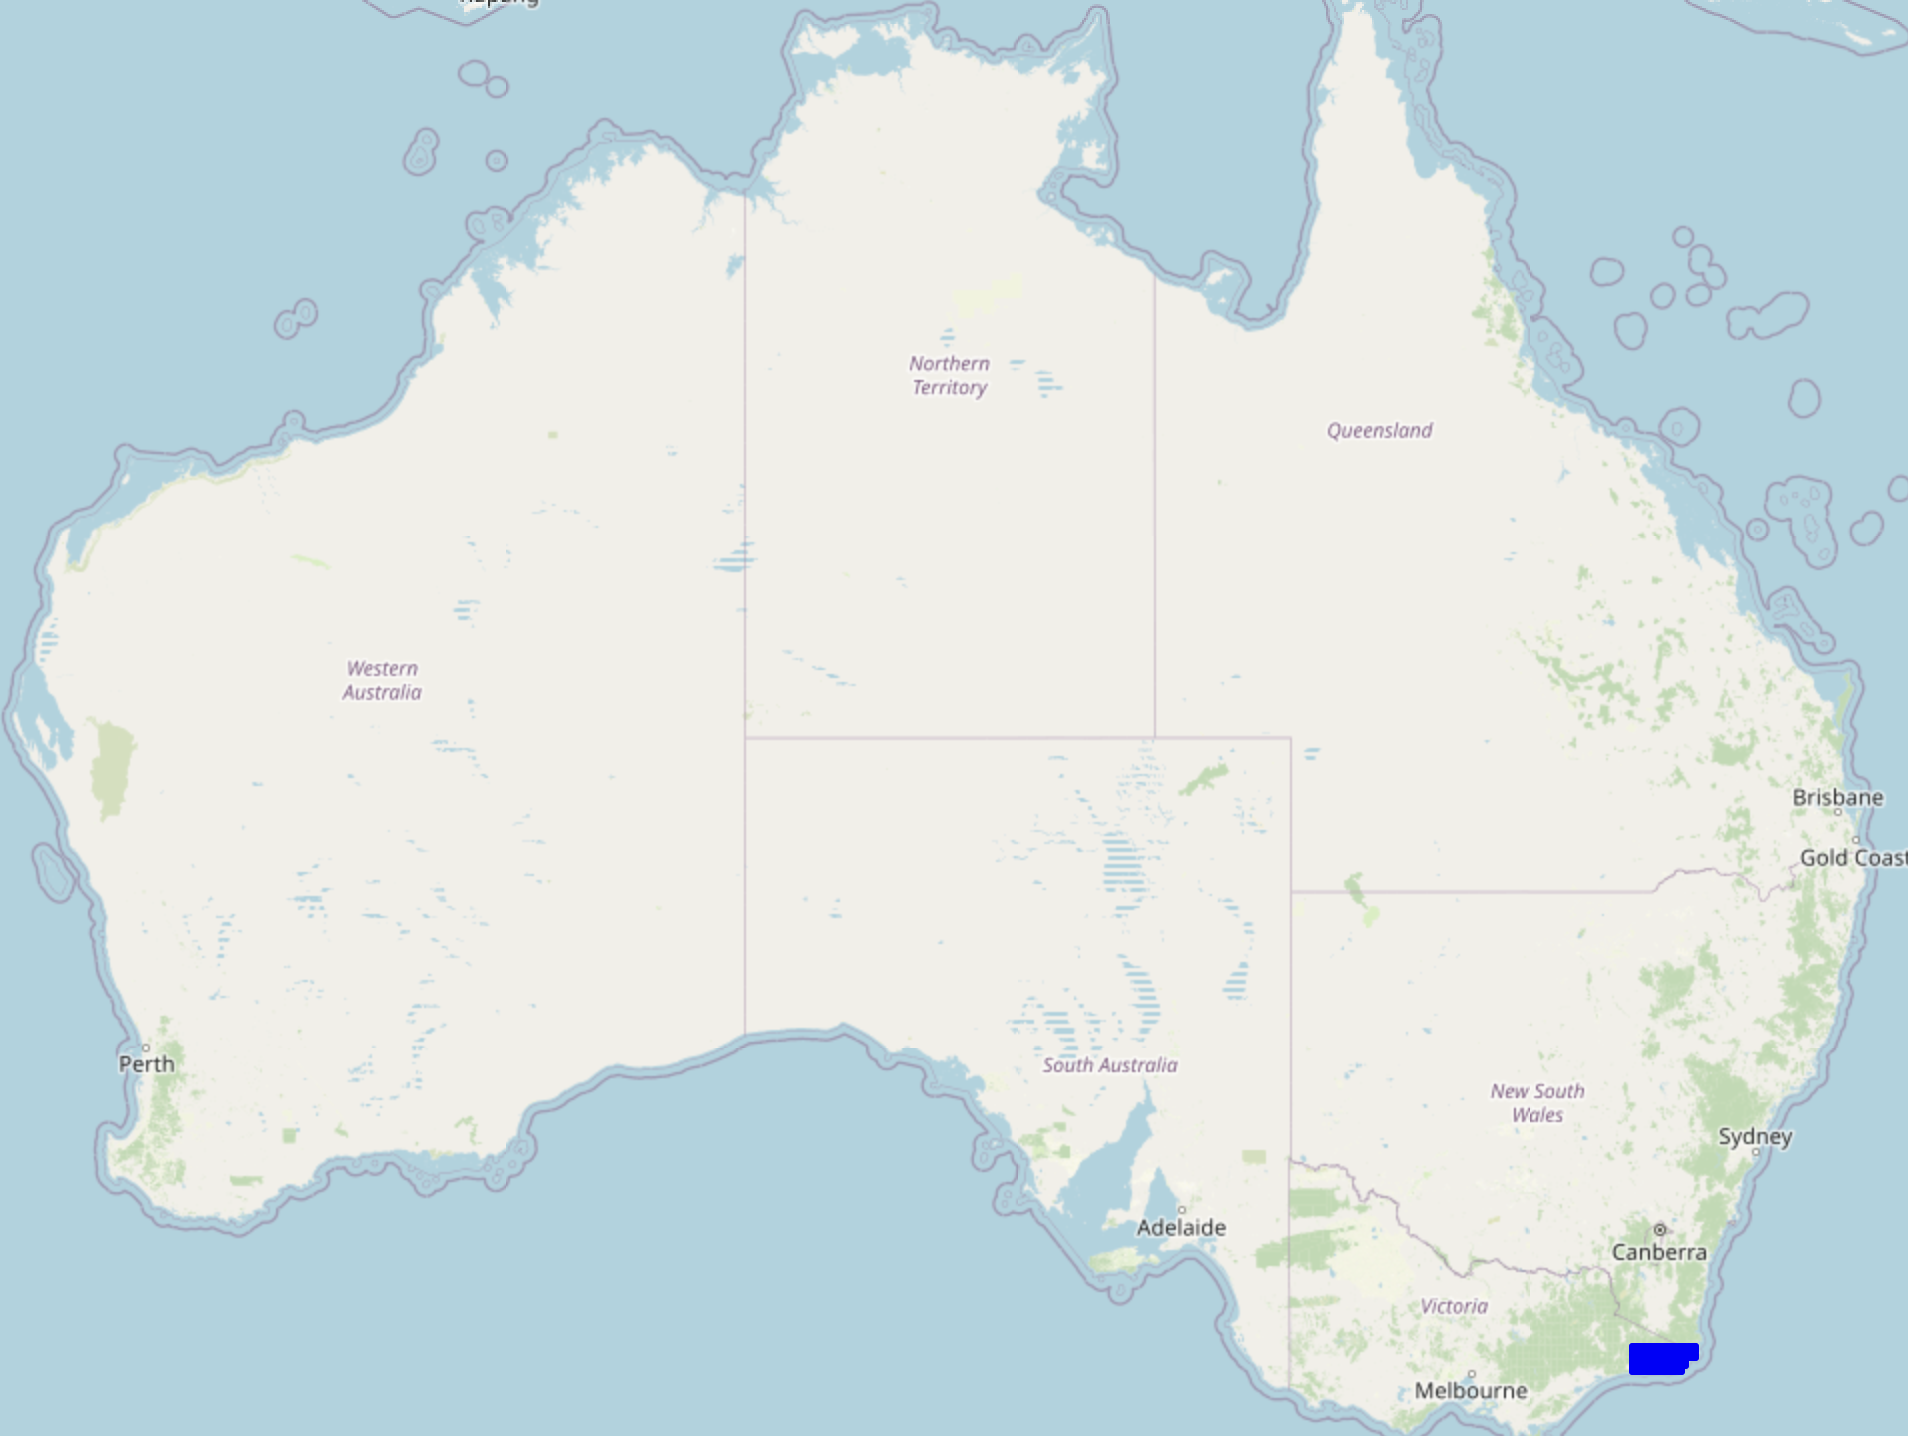

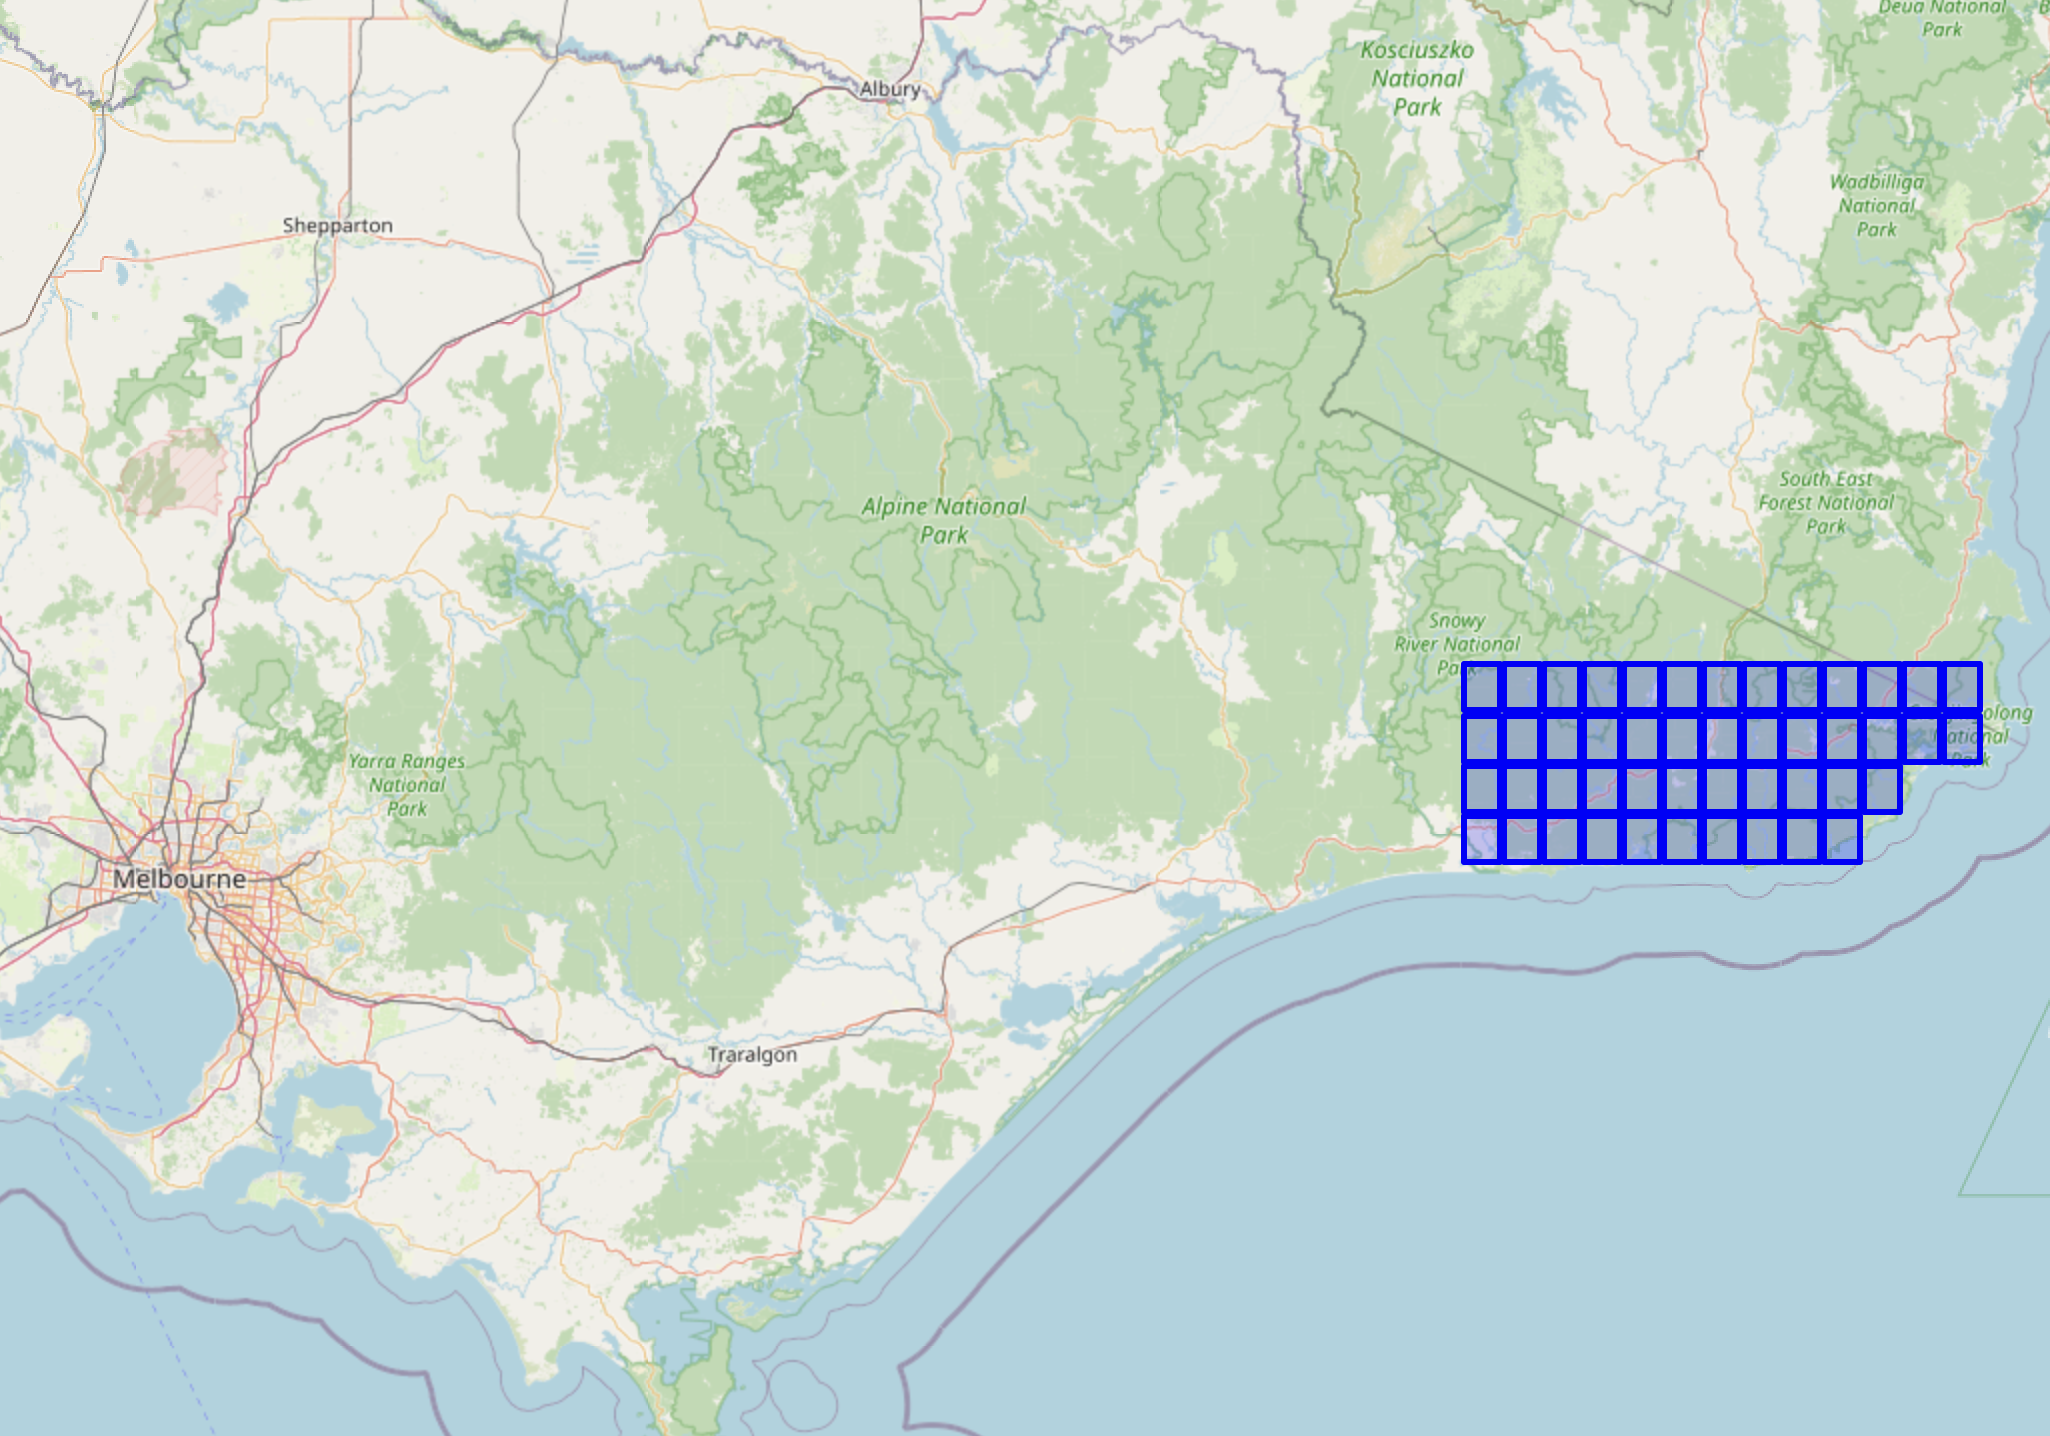

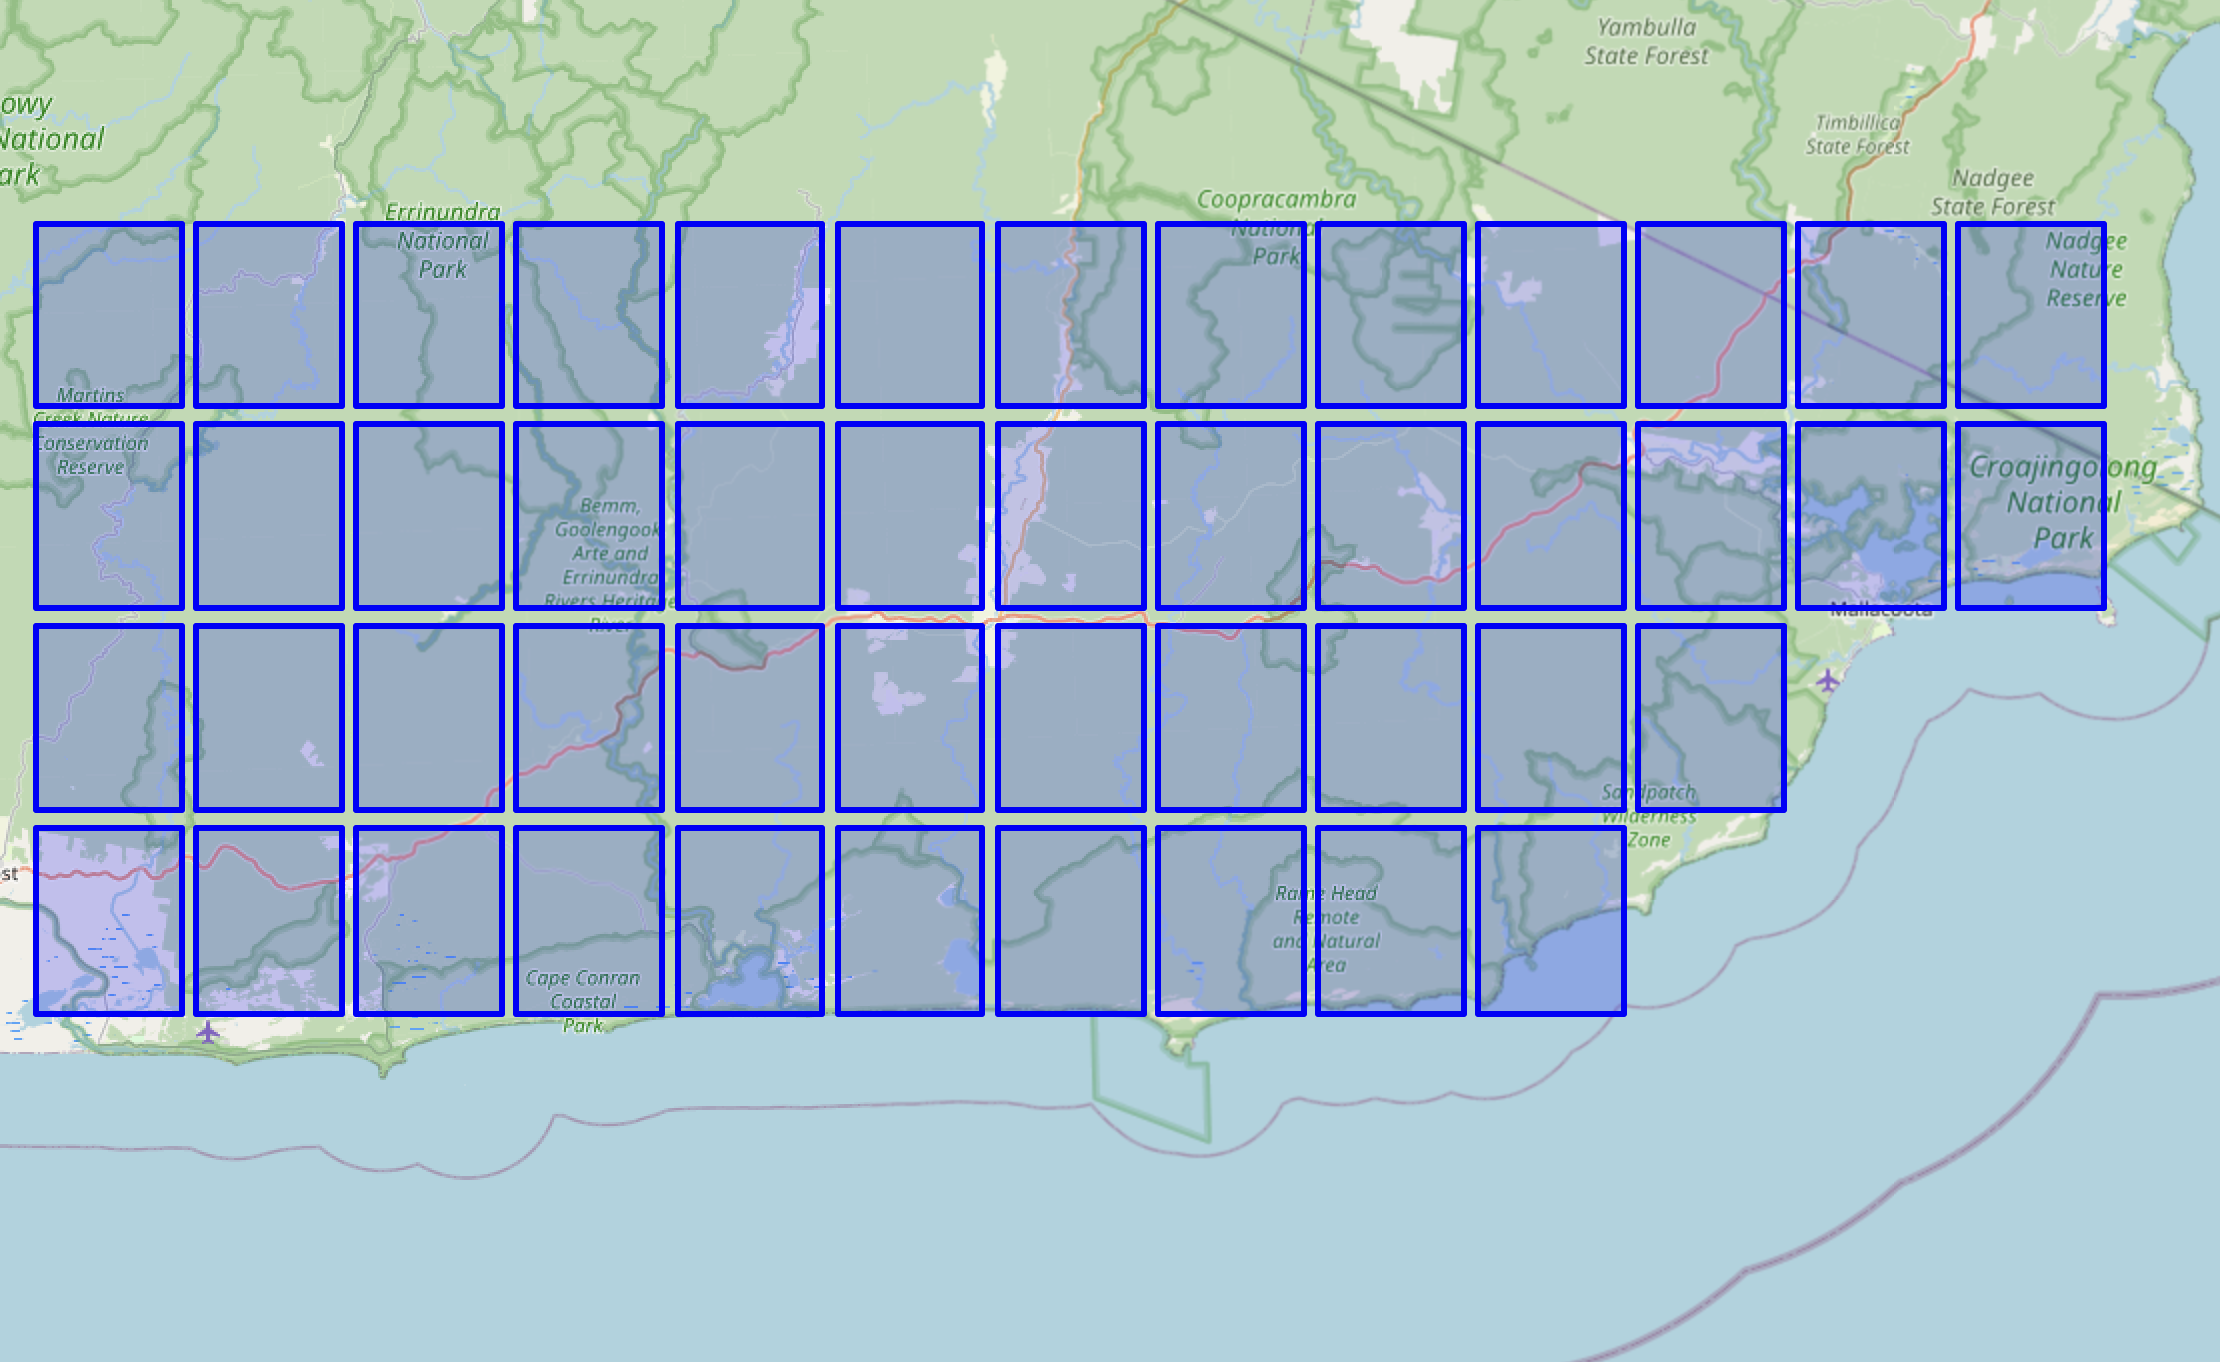

### Establishing the Database

The team used SQLite to stand up a database on the NPS HPC. This was accomplished as part of the .py script that is run on the HPC. The following code is broken out from the .py script in order to detail the process.

In [ ]:
def setup_database(db_path):
    """
    Initialize the database from CSV file and set up required columns.
    
    Args:
        db_path (str): Path to the SQLite database file
        
    Raises:
        FileNotFoundError: If CSV file is not found
        pd.errors.EmptyDataError: If CSV file is empty
        sqlite3.Error: If database operations fail
    """
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        # Read and process CSV file
        try:
            print("Reading CSV file...")
            df = pd.read_csv('./Data/base_data_1986-2018.csv')
        except FileNotFoundError:
            print("Error: base_data_1986-2018.csv not found in Data directory")
            sys.exit(1)
        except pd.errors.EmptyDataError:
            print("Error: CSV file is empty")
            sys.exit(1)
        
        # Clean and transform data
        print("Processing CSV data...")
        df.drop(['time', 'index_right'], axis=1, inplace=True)
        df.month = pd.to_datetime(df.month, format='%Y-%m')
        df = df[df['month'].dt.year != 1986]
        
        # Create database table
        print("Creating database table...")
        df.to_sql('ground_data', conn, if_exists='replace', index=False)
        
        # Define and add new columns for percentile data
        columns_to_add = [
            'bs_pc_10 REAL DEFAULT NAN',  # Bare soil 10th percentile
            'bs_pc_50 REAL DEFAULT NAN',  # Bare soil 50th percentile
            'bs_pc_90 REAL DEFAULT NAN',  # Bare soil 90th percentile
            'pv_pc_10 REAL DEFAULT NAN',  # Photosynthetic vegetation 10th percentile
            'pv_pc_50 REAL DEFAULT NAN',  # Photosynthetic vegetation 50th percentile
            'pv_pc_90 REAL DEFAULT NAN',  # Photosynthetic vegetation 90th percentile
            'npv_pc_10 REAL DEFAULT NAN', # Non-photosynthetic vegetation 10th percentile
            'npv_pc_50 REAL DEFAULT NAN', # Non-photosynthetic vegetation 50th percentile
            'npv_pc_90 REAL DEFAULT NAN'  # Non-photosynthetic vegetation 90th percentile
        ]
        
        print("Adding percentile columns...")
        for column in columns_to_add:
            column_name = column.split()[0]
            if not column_exists(cursor, 'ground_data', column_name):
                cursor.execute(f'ALTER TABLE ground_data ADD COLUMN {column}')
        
        conn.commit()
        print("Database setup completed successfully")
        
    except sqlite3.Error as e:
        print(f"Database error during setup: {e}")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error during setup: {e}")
        sys.exit(1)
    finally:
        cursor.close()
        conn.close()

The code initializes the database off of a csv file containing the base data shown under the data source section. Once the database is established, the data is cleaned and columns are added for the variables of interest, finally the the database is committed and the cursor/connection are closed.

Once the database is established, subsets of the data can easily be pulled for analysis. This can be achieved directly from the database, or by exporting a seperate file (e.g. .csv or .parquet). The following code is an example of how to pull a subset of the data from the database. For this example we will use the bounding box of our truncated region of interest.

In [ ]:
import sqlite3
import pandas as pd

def query_data_within_bbox(db_path, lat_min, lat_max, lon_min, lon_max):
    """
    Query data within a specific latitude and longitude bounding box.
    
    Args:
        db_path (str): Path to the SQLite database file
        lat_min (float): Minimum latitude
        lat_max (float): Maximum latitude
        lon_min (float): Minimum longitude
        lon_max (float): Maximum longitude
        
    Returns:
        pd.DataFrame: DataFrame containing the queried data
    """
    conn = sqlite3.connect(db_path)
    query = f"""
    SELECT * FROM ground_data
    WHERE lat BETWEEN {lat_min} AND {lat_max}
    AND lon BETWEEN {lon_min} AND {lon_max}
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def save_to_csv(df, file_path):
    """
    Save DataFrame to a CSV file.
    
    Args:
        df (pd.DataFrame): DataFrame to save
        file_path (str): Path to the CSV file
    """
    df.to_csv(file_path, index=False)
    print(f"Data saved to {file_path}")

def save_to_parquet(df, file_path):
    """
    Save DataFrame to a Parquet file.
    
    Args:
        df (pd.DataFrame): DataFrame to save
        file_path (str): Path to the Parquet file
    """
    df.to_parquet(file_path, index=False)
    print(f"Data saved to {file_path}")

# Example usage
db_path = 'fire.db'
bbox = [148.54, -37.73, 149.86, -37.4]

# Query data within bounding box
df_bbox = query_data_within_bbox(db_path, bbox[1], bbox[3], bbox[0], bbox[2])

# An example of three options to save the truncated subset for local use:

## 1 - Save to a new table in the database
df_bbox.to_sql('data_within_bbox', conn, if_exists='replace', index=False)

## 2 - Save to CSV
save_to_csv(df_bbox, 'data_within_bbox.csv')

## 3 - Save to Parquet
save_to_parquet(df_bbox, 'data_within_bbox.parquet')

Note that for much of the local analysis, downloading the data from the shared HPC folder as a paquet file was very efficeint. This allowed for use without connection to the NPS network; and gave a file size of just 700KB as opposed to making a local copy of the database (4MB). Although this saving does not seem significant with truncated data, this approximatly 90% reduction in storage requirement becomes substantial when using the full dataset.

Parquet was found to be a very effiecient and user friendly option for data export. Parquet is a columnar storage format that organizes data by columns rather than rows, enabling selective column reads and significantly reducing I/O operations. This structure, combined with efficient compression, results in smaller file sizes and faster performance compared to CSV, making it ideal for large datasets and analytical workloads.

## API Calls
In order to get the data files extracted from the TIFF files, the group used API calls to the https://explorer.dea.ga.gov.au/stac

The Open Data Cube (ODC) is a free and open-source software platform that streamlines the management and analysis of large-scale satellite imagery and Earth observation data. It enables users to efficiently access, process, and analyze decades of geospatial data, facilitating the study of Earth's surface changes over time. Designed for scientists, researchers, and government agencies, ODC supports informed decision-making in fields such as environmental monitoring, land use planning, and resource management.

The script below processes ground data from a SQLite database, fetches corresponding satellite data
from the Digital Earth Australia STAC catalog, and updates the database with processed results.
It supports both sequential and parallel processing modes and can initialize the database from
a CSV file if needed.

Dependencies: <br>
    - sqlite3: For database operations <br>
    - pandas: For data manipulation<br>
    - pystac_client: For accessing STAC catalog <br>
    - odc.stac: For loading satellite data <br>

### Full API Script

Below is a python script with comments that establishes a new database, conducts the API call, and inserts the required data into the SQLite database.

In [ ]:
import sqlite3
import pandas as pd
import pystac_client
import odc.stac

from multiprocessing import Pool, Manager
from functools import partial

import sys
import argparse

def get_all_years(cursor):
    """
    Retrieve all distinct years from the ground_data table.
    
    Args:
        cursor: SQLite database cursor
        
    Returns:
        list: List of years as strings
    """
    sql_query = '''
    SELECT DISTINCT strftime('%Y', month) as year FROM ground_data
    ORDER BY year
    '''
    cursor.execute(sql_query)
    return [row[0] for row in cursor.fetchall()]

def get_month_lat_long(cursor, year):
    """
    Retrieve records that need processing for a given year.
    
    Args:
        cursor: SQLite database cursor
        year (str): Year to process
        
    Returns:
        list: List of tuples containing (month, latitude, longitude, grid_id)
              for records with NAN values in processing columns
    """
    sql_query = '''
    SELECT month, lat, lon, grid_id 
    FROM ground_data 
    WHERE strftime('%Y', month) = ? 
    AND (bs_pc_10 IS 'NAN' OR bs_pc_50 IS 'NAN' OR bs_pc_90 IS 'NAN' 
    OR pv_pc_10 IS 'NAN' OR pv_pc_50 IS 'NAN' OR pv_pc_90 IS 'NAN' 
    OR npv_pc_10 IS 'NAN' OR npv_pc_50 IS 'NAN' OR npv_pc_90 IS 'NAN')
    '''
    cursor.execute(sql_query, (year,))
    return cursor.fetchall()

def column_exists(cursor, table_name, column_name):
    """
    Check if a column exists in a specified table.
    
    Args:
        cursor: SQLite database cursor
        table_name (str): Name of the table
        column_name (str): Name of the column to check
        
    Returns:
        bool: True if column exists, False otherwise
    """
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = [info[1] for info in cursor.fetchall()]
    return column_name in columns

def update_ground_data(cursor, conn, data):
    """
    Update a record in the ground_data table with processed values.
    
    Args:
        cursor: SQLite database cursor
        conn: SQLite database connection
        data (dict): Dictionary containing values to update
        
    Raises:
        sqlite3.Error: If database operation fails
    """
    try:
        # SQL query to update all percentile columns for a specific grid_id and month
        cursor.execute('''
        UPDATE ground_data
        SET bs_pc_10 = ?, bs_pc_50 = ?, bs_pc_90 = ?, 
            pv_pc_10 = ?, pv_pc_50 = ?, pv_pc_90 = ?, 
            npv_pc_10 = ?, npv_pc_50 = ?, npv_pc_90 = ?
        WHERE grid_id = ? AND month = ?
        ''', (
            data['bs_pc_10'], data['bs_pc_50'], data['bs_pc_90'],
            data['pv_pc_10'], data['pv_pc_50'], data['pv_pc_90'],
            data['npv_pc_10'], data['npv_pc_50'], data['npv_pc_90'],
            data['grid_id'], data['time']
        ))
        conn.commit()
    except sqlite3.Error as e:
        print(f"Database error during update: {e}")
        raise
    except Exception as e:
        print(f"Unexpected error during update: {e}")
        raise

def setup_database(db_path):
    """
    Initialize the database from CSV file and set up required columns.
    
    Args:
        db_path (str): Path to the SQLite database file
        
    Raises:
        FileNotFoundError: If CSV file is not found
        pd.errors.EmptyDataError: If CSV file is empty
        sqlite3.Error: If database operations fail
    """
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        # Read and process CSV file
        try:
            print("Reading CSV file...")
            df = pd.read_csv('./Data/base_data_1986-2018.csv')
        except FileNotFoundError:
            print("Error: base_data_1986-2018.csv not found in Data directory")
            sys.exit(1)
        except pd.errors.EmptyDataError:
            print("Error: CSV file is empty")
            sys.exit(1)
        
        # Clean and transform data
        print("Processing CSV data...")
        df.drop(['time', 'index_right'], axis=1, inplace=True)
        df.month = pd.to_datetime(df.month, format='%Y-%m')
        df = df[df['month'].dt.year != 1986]
        
        # Create database table
        print("Creating database table...")
        df.to_sql('ground_data', conn, if_exists='replace', index=False)
        
        # Define and add new columns for percentile data
        columns_to_add = [
            'bs_pc_10 REAL DEFAULT NAN',  # Bare soil 10th percentile
            'bs_pc_50 REAL DEFAULT NAN',  # Bare soil 50th percentile
            'bs_pc_90 REAL DEFAULT NAN',  # Bare soil 90th percentile
            'pv_pc_10 REAL DEFAULT NAN',  # Photosynthetic vegetation 10th percentile
            'pv_pc_50 REAL DEFAULT NAN',  # Photosynthetic vegetation 50th percentile
            'pv_pc_90 REAL DEFAULT NAN',  # Photosynthetic vegetation 90th percentile
            'npv_pc_10 REAL DEFAULT NAN', # Non-photosynthetic vegetation 10th percentile
            'npv_pc_50 REAL DEFAULT NAN', # Non-photosynthetic vegetation 50th percentile
            'npv_pc_90 REAL DEFAULT NAN'  # Non-photosynthetic vegetation 90th percentile
        ]
        
        print("Adding percentile columns...")
        for column in columns_to_add:
            column_name = column.split()[0]
            if not column_exists(cursor, 'ground_data', column_name):
                cursor.execute(f'ALTER TABLE ground_data ADD COLUMN {column}')
        
        conn.commit()
        print("Database setup completed successfully")
        
    except sqlite3.Error as e:
        print(f"Database error during setup: {e}")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error during setup: {e}")
        sys.exit(1)
    finally:
        cursor.close()
        conn.close()

def process_single_tile(data, catalog, year):
    """
    Process a single tile of data using the STAC catalog.
    
    Args:
        data (tuple): Contains (month, lat, lon, grid_id)
        catalog: STAC catalog client
        year (str): Year being processed
        
    Returns:
        dict: Processed data dictionary or None if processing fails
    """
    try:
        # Calculate bounding box for the tile
        bbox = [data[2] - 0.05, data[1] - 0.05, data[2] + 0.05, data[1] + 0.05]
        start_date = f"{data[0][:4]}-01-01"
        end_date = f"{data[0][:4]}-12-31"
        
        # Query STAC catalog
        query = catalog.search(
            bbox=bbox,
            collections=["ga_ls_fc_pc_cyear_3"],
            datetime=f"{start_date}/{end_date}",
        )
        
        items = list(query.items())
        if not items:
            print(f"No data found for {start_date}-{end_date}, Location: {data[1]}, {data[2]}")
            return None
        
        # Load and process data
        ds = odc.stac.load(
            items=items,
            crs="EPSG:3577",
            lat=(bbox[1], bbox[3]),
            lon=(bbox[0], bbox[2]),
            time=(start_date, end_date)
        )
        
        # Calculate means for all percentiles
        return {
            'time': data[0],
            'grid_id': data[3],
            'bs_pc_10': float(ds.bs_pc_10.mean().values),
            'bs_pc_50': float(ds.bs_pc_50.mean().values),
            'bs_pc_90': float(ds.bs_pc_90.mean().values),
            'pv_pc_10': float(ds.pv_pc_10.mean().values),
            'pv_pc_50': float(ds.pv_pc_50.mean().values),
            'pv_pc_90': float(ds.pv_pc_90.mean().values),
            'npv_pc_10': float(ds.npv_pc_10.mean().values),
            'npv_pc_50': float(ds.npv_pc_50.mean().values),
            'npv_pc_90': float(ds.npv_pc_90.mean().values)
        }
        
    except Exception as e:
        print(f"Error processing year {year}, location {data[1]}, {data[2]}: {e}")
        return None

def process_single_year(year, db_path):
    """
    Process all tiles for a given year.
    
    Args:
        year (str): Year to process
        db_path (str): Path to SQLite database
    """
    try:
        # Get data tiles that need processing
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        data_tiles = get_month_lat_long(cursor, year)
        cursor.close()
        conn.close()
        
        print(f"Processing {len(data_tiles)} tiles for year: {year}")
        
        # Initialize STAC catalog and configure AWS connection
        catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")
        odc.stac.configure_rio(
            cloud_defaults=True,
            aws={"aws_unsigned": True},
        )
        
        # Process each tile and update database
        for data in data_tiles:
            result = process_single_tile(data, catalog, year)
            if result:
                conn = sqlite3.connect(db_path)
                cursor = conn.cursor()
                update_ground_data(cursor, conn, result)
                cursor.close()
                conn.close()
                
    except Exception as e:
        print(f"Error in process_single_year for year {year}: {e}")

def main():
    """
    Main function to orchestrate the data processing workflow.
    Handles command line arguments and initiates processing.
    """
    # Set up command line argument parsing
    parser = argparse.ArgumentParser(description='Process ground data with optional parallel processing')
    parser.add_argument('--first', action='store_true', help='Initialize database')
    parser.add_argument('--parallel', action='store_true', help='Enable parallel processing')
    parser.add_argument('--db-path', default='fire.db', help='Path to database file')
    args = parser.parse_args()
    
    try:
        # Initialize database if requested
        if args.first:
            print("Initializing database...")
            setup_database(args.db_path)
        
        # Get list of years to process
        conn = sqlite3.connect(args.db_path)
        cursor = conn.cursor()
        years = get_all_years(cursor)
        cursor.close()
        conn.close()
        
        # Process years either in parallel or sequentially
        if args.parallel:
            print("Running with parallel processing...")
            with Pool() as pool:
                pool.map(partial(process_single_year, db_path=args.db_path), years)
        else:
            print("Running with sequential processing...")
            for year in years:
                process_single_year(year, args.db_path)
                
    except Exception as e:
        print(f"Critical error in main: {e}")
        sys.exit(1)

if __name__ == '__main__':
    main()


### Running on HPC

Below is a copy of the Shell file used to run the above Script on HPC.

The firefighter.sh script requests 16GB of memory and runs 2 tasks per node when assigning and executing the meltdown.py script.

Note the use of the multiprocessing library to run the script in parallel. This was done to speed up the process of pulling the data from the API. The script was run on with 16 cores per node. The script was run with 2 tasks per node, which allowed for 8 nodes to be used at a time. This significantly accelerated the process of pulling the data from the API; leveraging SQlite's capabilities to handle multiple writes at once.

In [ ]:
#!/bin/sh
#SBATCH --job-name globalMeltdown
#SBATCH --nodes=1 --tasks-per-node=2 --mem=16GB
#SBATCH --output=%j_log.txt
#SBATCH --time 0-24:00:00
#SBATCH --mail-user conrad.urban.gy@nps.edu
#SBATCH --mail-type END 

. /etc/profile
source /smallwork/$USER/comp3/bin/activate

python meltdown.py

The following command should be ran on HPC in order to execute the script:
    
    sbatch firefighter.sh

# Data Visualization
The group used PowerBI to produce visualizations depecting vegetation levels across the region assessed and bushfire counts by year/latitude/longitude. (Dashboard example available within repo at Firetrucks_PowerBI.pbix)


Jason, please give some detail of a tutorial of how you did the visualization.

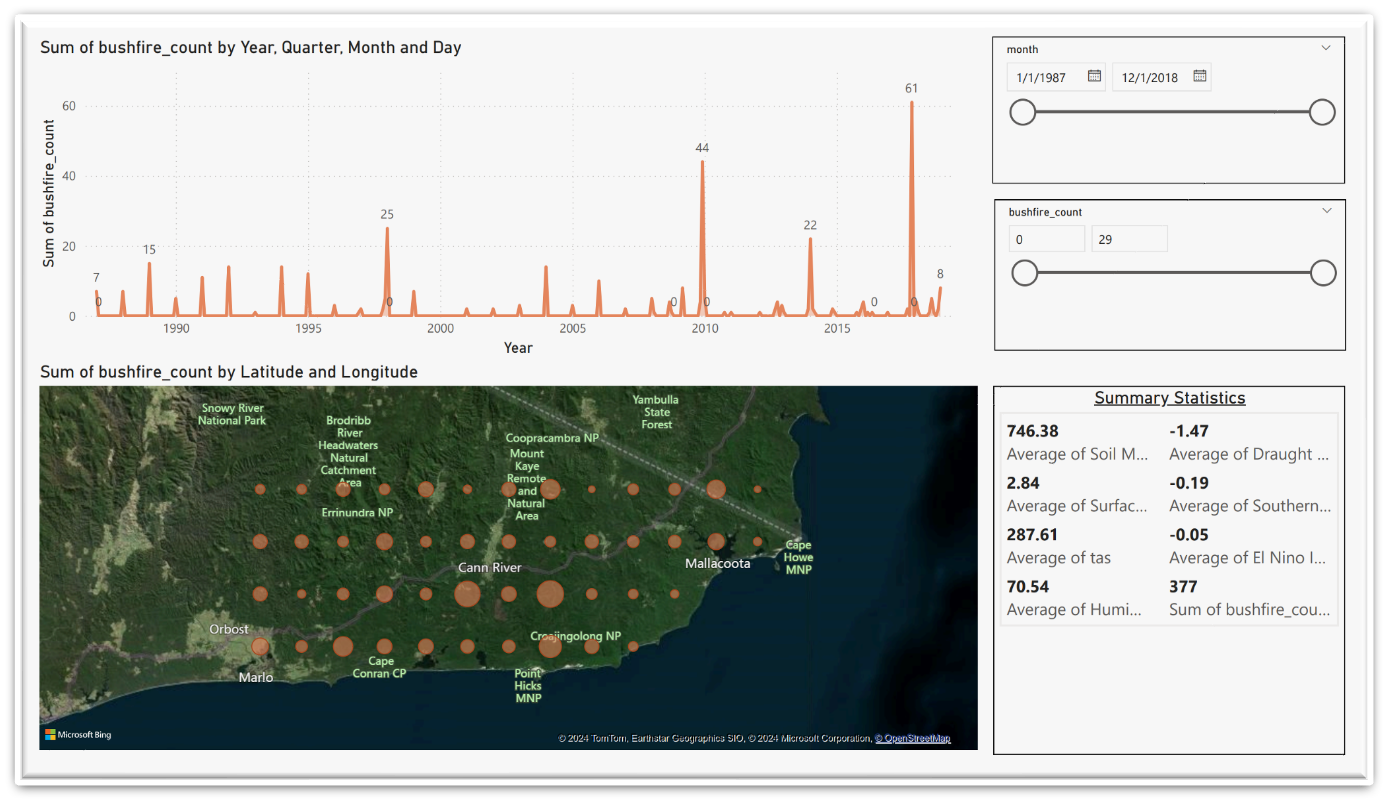